<a href="https://colab.research.google.com/github/Sep-eg/kagglestudy/blob/main/Porto/BCT_2lv_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

이 노트는 PorteSeguro 대회의 데이터에 대한 통찰력을 얻는 것을 목표로 합니다. 그 외에도 모델링을 위해 데이터를 준비할 수 있는 몇 가지 팁과 요령을 제공합니다. 노트북은 다음과 같은 주요 섹션으로 구성되어 있습니다.

1. Visual inspection of your data
2. Defining the metadata
3. Descriptive statistics
4. Handling imbalanced classes
5. Data quality checks
6. Exploratory data visualization
7. Feature engineering
8. Feature selection
9. Feature scaling

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!kaggle competitions download -c porto-seguro-safe-driver-prediction

 83% 25.0M/30.0M [00:00<00:00, 30.5MB/s]
100% 30.0M/30.0M [00:00<00:00, 50.8MB/s]
 92% 41.0M/44.4M [00:00<00:00, 24.4MB/s]
100% 44.4M/44.4M [00:00<00:00, 48.2MB/s]
  0% 0.00/2.12M [00:00<?, ?B/s]
100% 2.12M/2.12M [00:00<00:00, 143MB/s]


In [2]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


## Loading packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

## Loading data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

<a class="anchor" id="visual_inspection"></a>

## Data at first sight

다음은 대회에 대한 데이터 설명의 발췌문입니다.
* **유사 그룹에 속하는 형상**은 형상 이름(예: ind, reg, car, calc)에서와 같이 **태그가 지정**된다.
* 피쳐 이름에는 이진 피쳐를 나타내는 사후 수정 **bin**과 범주형 피쳐를 나타내는 **cat**이 포함됩니다. 
* 이러한 지정이 없는 **피쳐는 연속형 또는 순서형**입니다. 
* **-1**의 값은 형상이 관측치에서 **누락**되었음을 나타냅니다. 
* **target** 열은 해당 정책 소유자에 대한 클레임이 접수되었는지 여부를 나타냅니다.

좋아요, 시작하는데 중요한 정보네요. 이 모든 것을 확인하기 위해 첫 번째 행과 마지막 행을 간단히 살펴보겠습니다.

In [5]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [6]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


우리는 실제로 다음을 본다.
* 이진 변수
* 범주 값이 정수인 범주형 변수
* 정수 또는 부동값을 갖는 기타 변수
* -1이 결측값을 나타내는 변수
* 대상 변수와 ID 변수

Let's look at the number of rows and columns in the train data.

In [7]:
train.shape

(595212, 59)

59개의 변수와 595.212개의 행이 있습니다. 검정 데이터에 같은 수의 변수가 있는지 알아보겠습니다.<br>
교육 데이터에 중복된 행이 있는지 확인해 보겠습니다.

In [8]:
train.drop_duplicates()
train.shape

(595212, 59)

No duplicate rows, so that's fine.

In [9]:
test.shape

(892816, 58)

테스트 세트에는 변수가 하나 누락되어 있지만 이것이 대상 변수입니다. 그러니까 괜찮아요.<br>
이제 각 유형별로 얼마나 많은 변수가 있는지 알아보겠습니다.

나중에 14개의 범주형 변수에 대한 더미 변수를 만들 수 있습니다. *bin* 변수는 이미 이진수이므로 더미화가 필요하지 않습니다.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

다시 info() 방법을 사용하면 데이터 형식이 정수 또는 부동임을 알 수 있습니다. 데이터 집합에 null 값이 없습니다. 결측값이 -1로 대체되기 때문에 정상입니다. 그건 나중에 알아보죠

<a class="anchor" id="metadata"></a>

## Metadata
데이터 관리를 용이하게 하기 위해 DataFrame의 변수에 대한 메타 정보를 저장하겠습니다. 분석, 시각화, 모델링 등을 위해 특정 변수를 선택하고 싶을 때 유용합니다.

구체적으로 다음 사항을 저장할 것입니다.
- **role**: input, ID, target
- **level**: norminal, interval, ordinal, binary
- **keep**: True or False
- **dtype**: int, float, str

In [11]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'

    # defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'

    # initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # defining the data type
    dtype = train[f].dtype

    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname' : f,
        'role' : role,
        'level' : level,
        'keep' : keep,
        'dtype' : dtype
    }
    data.append(f_dict)

meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [12]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Example to extract all nominal variables that are not dropped

In [13]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

Below the number of variables per role and level are displayed. 

In [14]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


<a class="anchor" id="descriptive_stats"></a>

## Descriptive statistics

우리는 데이터 프레임에 description 방법을 적용할 수도 있습니다. 그러나 범주형 변수와 id 변수에 대해 평균, std, ...을 계산하는 것은 그다지 의미가 없습니다. 범주형 변수는 나중에 시각적으로 살펴보겠습니다.

우리의 메타 파일 덕분에 우리는 기술 통계를 계산하고자 하는 변수를 쉽게 선택할 수 있다. 명확하게 하기 위해 데이터 유형별로 이 작업을 수행합니다.

### Interval variables

In [15]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


#### reg variables
- ps_reg_03에만 결측값이 있습니다.
- 범위(최소 ~ 최대)는 변수마다 다릅니다. 스케일링(예: StandardScaler)을 적용할 수 있지만 사용하려는 분류기에 따라 다릅니다.

#### car variables
- ps_car_12 및 ps_car_15에 결측값이 있습니다.
- 역시 범위가 다르므로 스케일링을 적용할 수 있습니다.

#### calc variables
- 결측값 없음
- 최대값이 0.9이므로 일종의 비율인 것 같습니다.
- 세 *_calc* 모두 분포가 매우 유사합니다.


**전반적으로** 구간 변수의 범위가 다소 작다는 것을 알 수 있습니다. 데이터를 익명화하기 위해 변환(예: 로그)이 이미 적용되었을 수 있습니다.


### Ordinal variables

In [16]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- 하나의 결측치가 있습니다.: ps_car_11
- 스케일링을 적용하여 다양한 범위를 처리할 수 있습니다.

### Binary variables

In [17]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 열차 데이터의 우선 순위는 3.645%로, **강력하게 불균형**입니다. 
- 평균으로부터 대부분의 변수에 대한 값이 0이라는 결론을 내릴 수 있습니다.

<a class="anchor" id="imbalanced_data"></a>

## Handling imbalanced classes
위에서 언급했듯이 target=1인 레코드의 비율은 target=0보다 훨씬 작습니다. 이는 정확도가 높지만 실제로는 부가가치가 있는 모델로 이어질 수 있습니다. 
이 문제를 해결할 수 있는 두 가지 전략은 다음과 같습니다.
* 대상=1로 레코드를 오버샘플링합니다. 
* target=0으로 레코드를 언더샘플링합니다.

물론 더 많은 전략이 있으며, MachineLearningMastery.com은 [nice overview](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)를 제공한다.
훈련 세트가 꽤 크기 때문에 **undersampling**을 할 수 있습니다.

In [18]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get ordinal number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


<a class="anchor" id="data_quality"></a>

## Data Quality Checks

### Checking missing values
Missings are represented as -1

In [19]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]

        print('Variable {} has {} records ({:.2%}) with missing values'
        .format(f, missings, missings_perc))
print('In total. there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total. there are 12 variables with missing values


- **ps_car_03_cat 및 ps_car_05_cat**에는 결측값이 있는 레코드 비율이 높습니다. 이 변수를 제거합니다.
- 결측값이 있는 다른 범주형 변수의 경우 결측값 -1을 그대로 둘 수 있습니다.
- **ps_reg_03**(연속)에 모든 레코드의 18%에 대한 결측값이 있습니다. 평균으로 대체합니다.
- **ps_car_11**(순서형)에는 불일치 값이 있는 레코드가 5개만 있습니다. 모드로 대체합니다.
- **ps_car_12**(연속)에 결측값이 있는 레코드가 1개뿐입니다. 평균으로 대체합니다.
- **ps_car_14**(연속)에는 모든 레코드의 7%에 대한 결측값이 있습니다. 평균으로 대체합니다.

In [20]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False # Updating the meta

#Imputing with the mean or mode
mean_imp = Imputer(missing_values=-1, strategy='mean')
mode_imp = Imputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

### Checking the cardinality of the categorical variables
카디널리티는 변수의 서로 다른 값의 수를 나타냅니다. 추후 범주형 변수에서 더미 변수를 만들 예정이기 때문에 구별되는 값이 많은 변수가 있는지 확인이 필요합니다. 우리는 이 변수들이 많은 더미 변수를 야기하기 때문에 그것들을 다르게 처리해야 합니다.

In [22]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


오직 **ps_car_11_cat**만이 구별되는 많은 값을 가지고 있지만 여전히 합리적입니다. 

**EDIT:** [nickycan](https://www.kaggle.com/nickycan)에서 첫 번째 솔루션이 데이터 유출로 이어질 수 있다는 사실에 대해 훌륭한 평가를 내렸습니다. 그는 또한 그것을 다루는 [oliver](https://www.kaggle.com/ogrellier)에서 만든 또 다른 커널을 가리켰다. 그래서 나는 이 부분을 올리버의 알맹이로 대체했다. 모든 신용은 그에게 돌아간다. Kaggle 대회에 참가함으로써 배울 수 있는 것이 너무 좋습니다:)

In [23]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [24]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

<a class="anchor" id="eda"></a>

## Exploratory Data Visualization

### Categorical variables
Let's look into the categorical variables and the proportion of customers with target = 1

<Figure size 432x288 with 0 Axes>

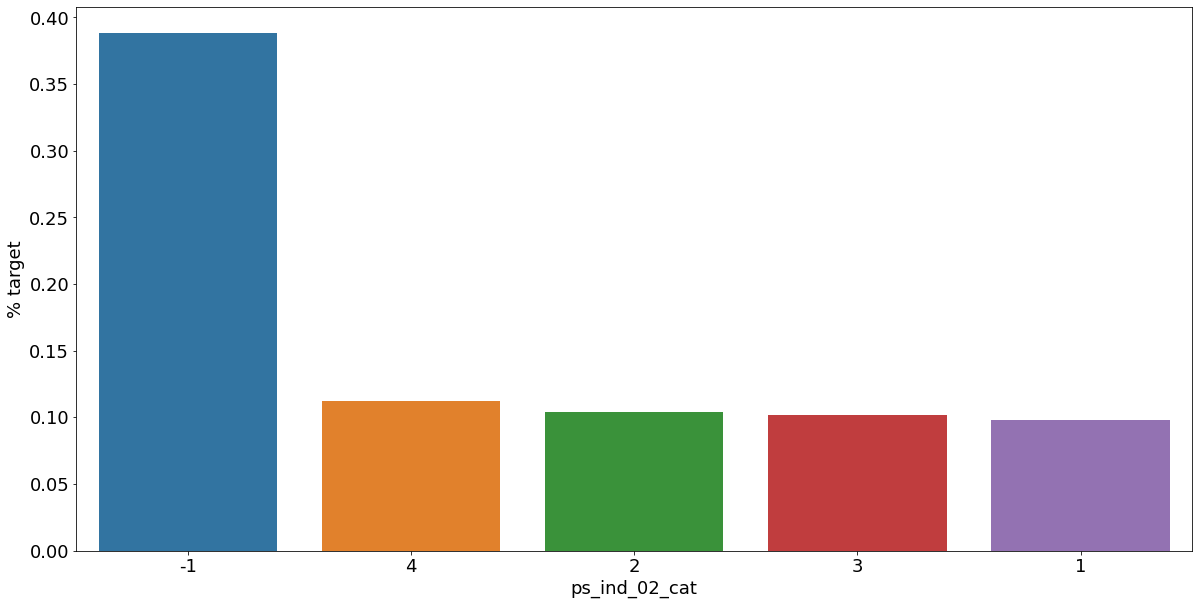

<Figure size 432x288 with 0 Axes>

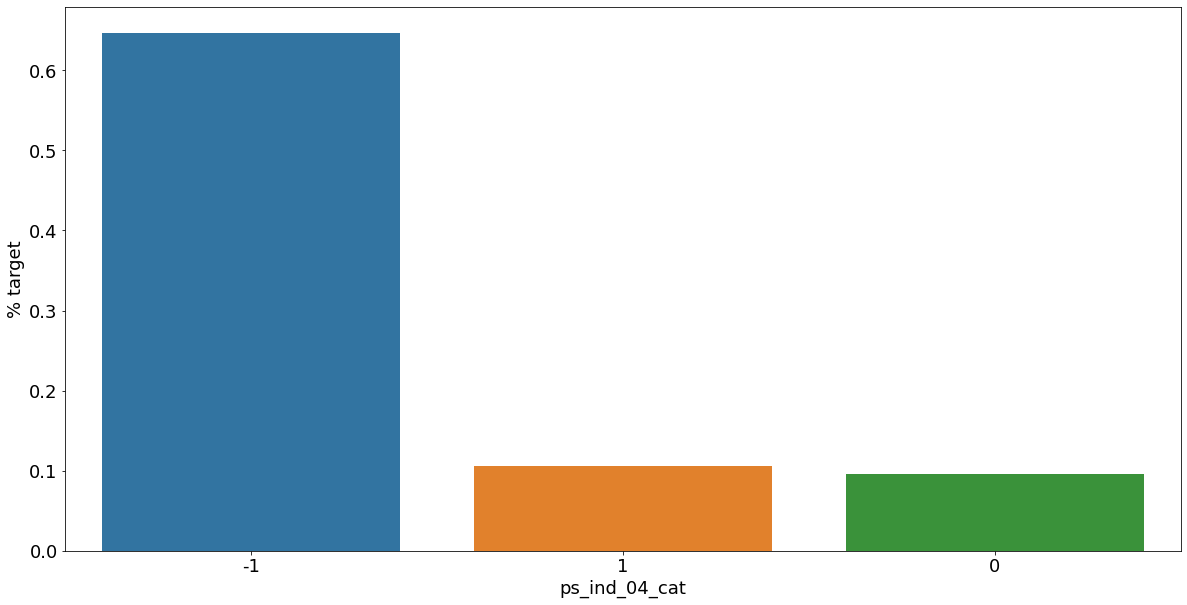

<Figure size 432x288 with 0 Axes>

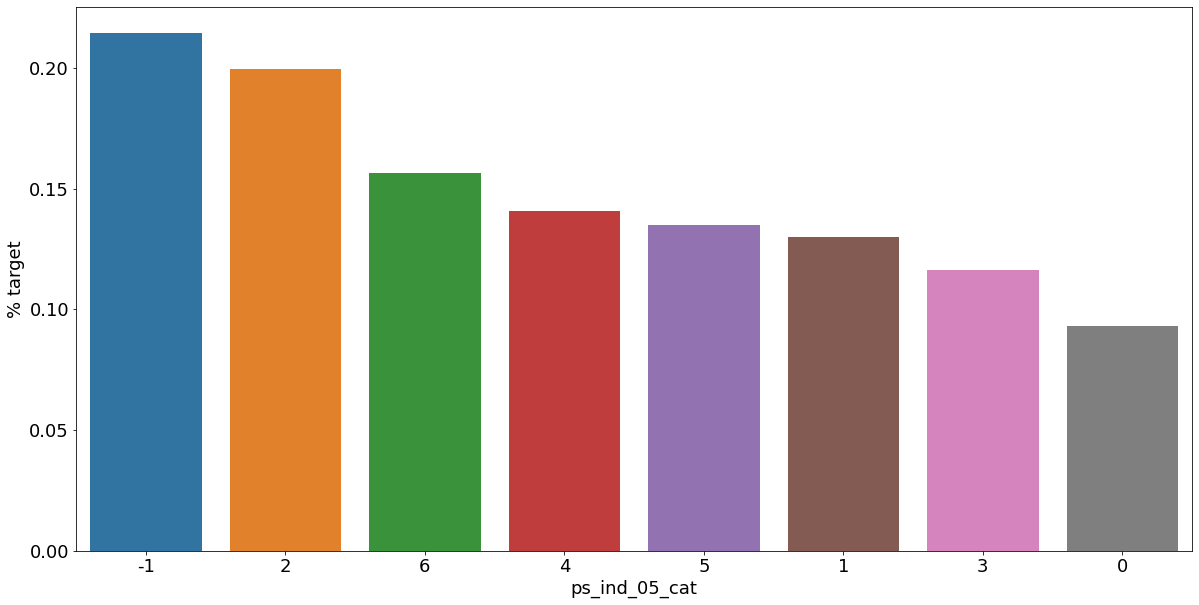

<Figure size 432x288 with 0 Axes>

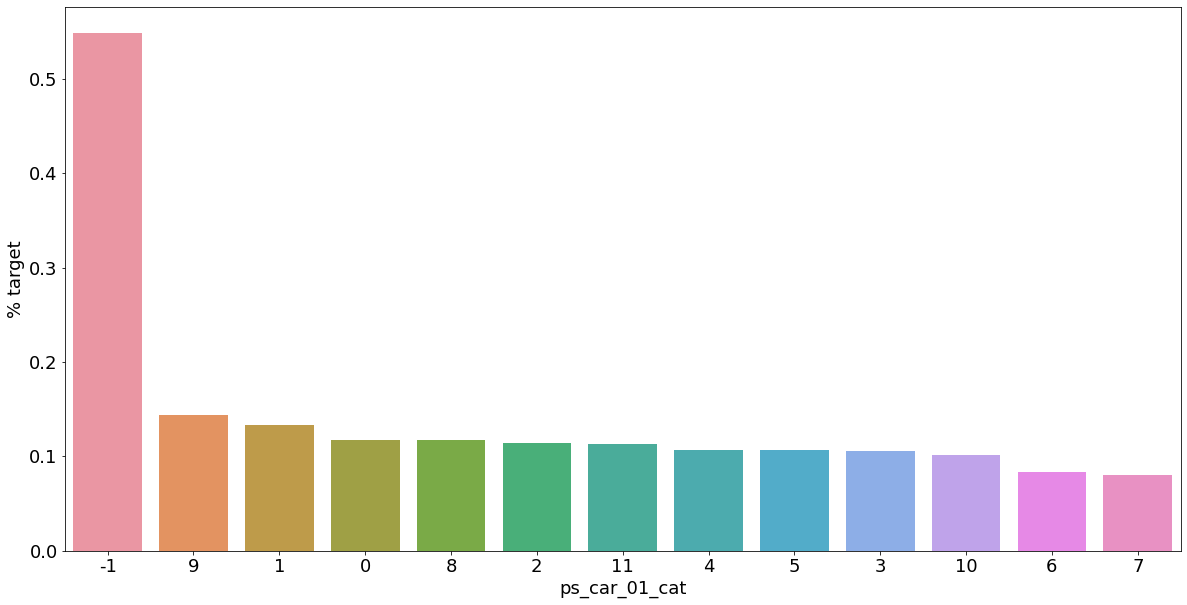

<Figure size 432x288 with 0 Axes>

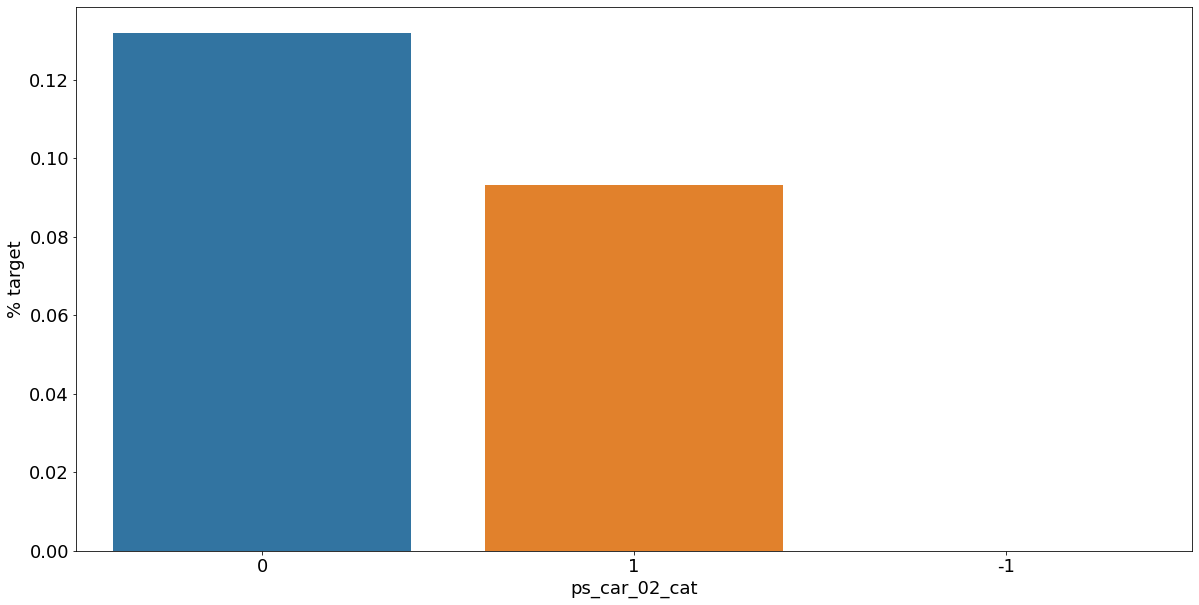

<Figure size 432x288 with 0 Axes>

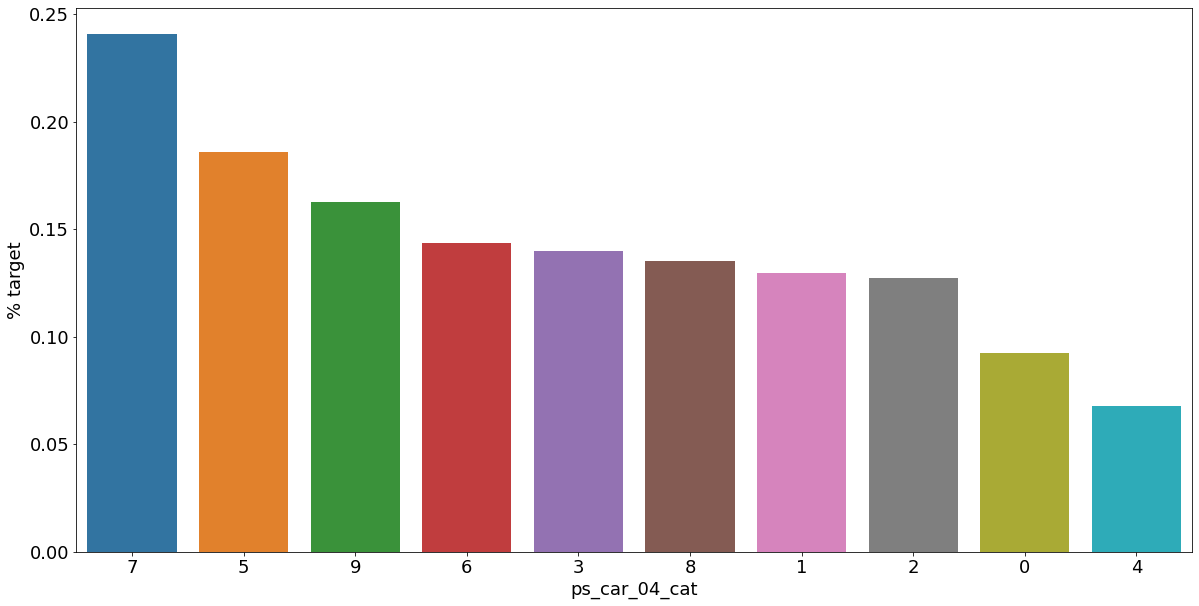

<Figure size 432x288 with 0 Axes>

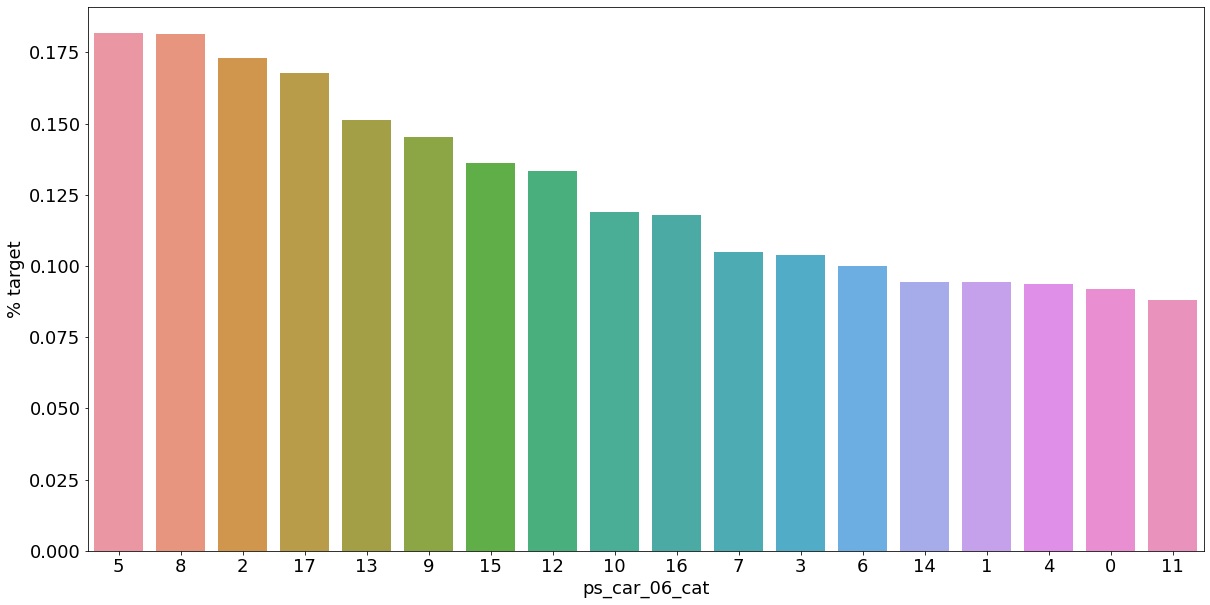

<Figure size 432x288 with 0 Axes>

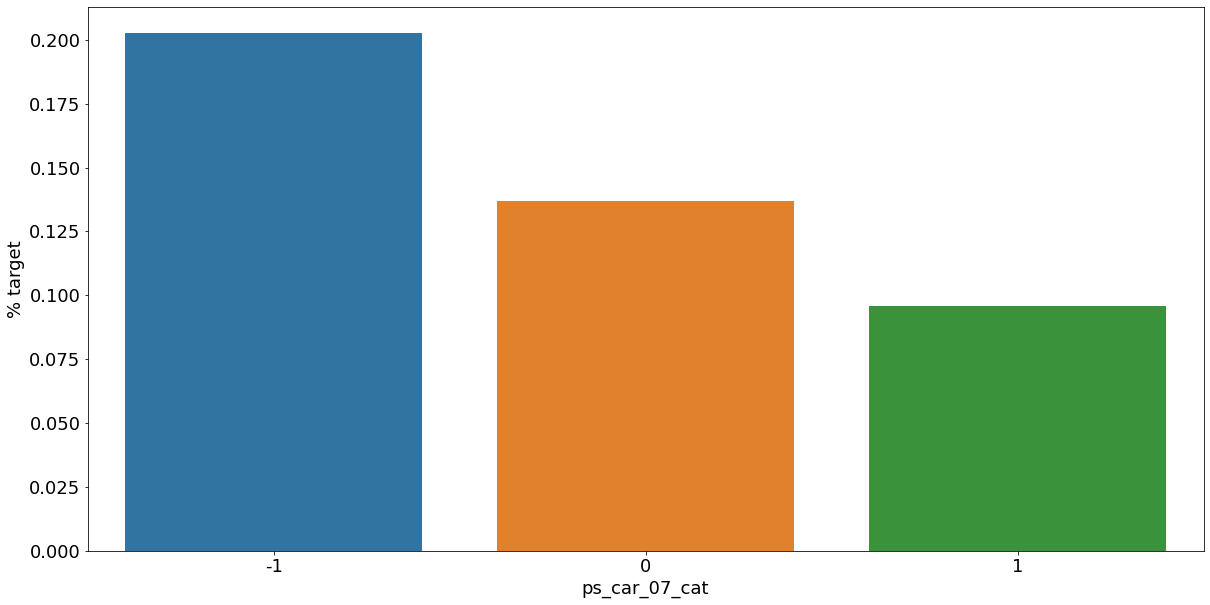

<Figure size 432x288 with 0 Axes>

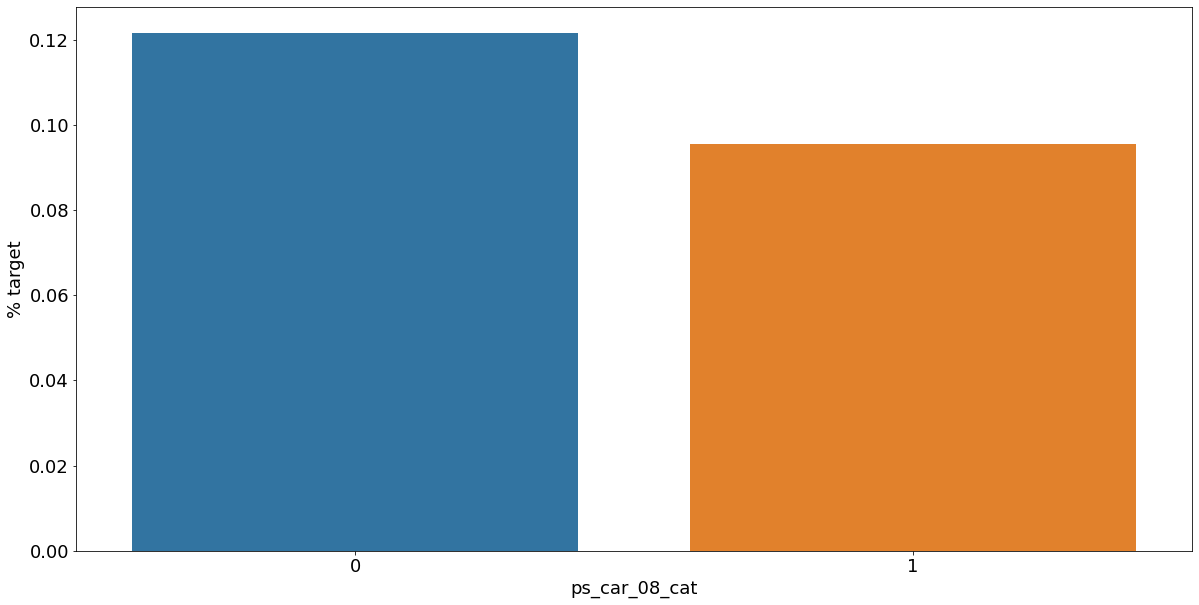

<Figure size 432x288 with 0 Axes>

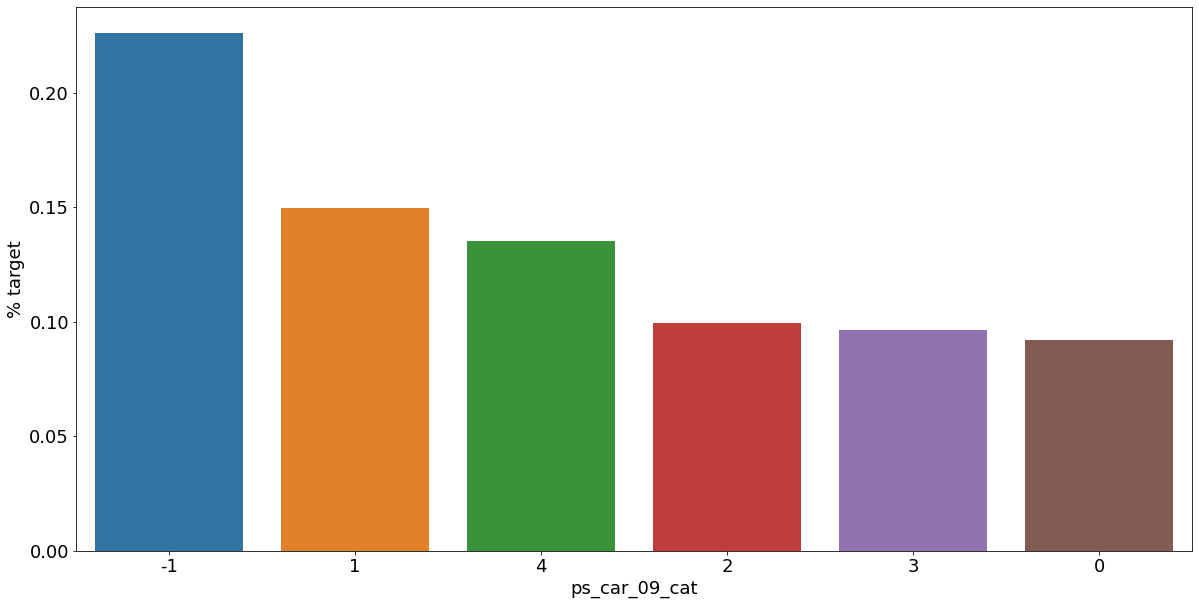

<Figure size 432x288 with 0 Axes>

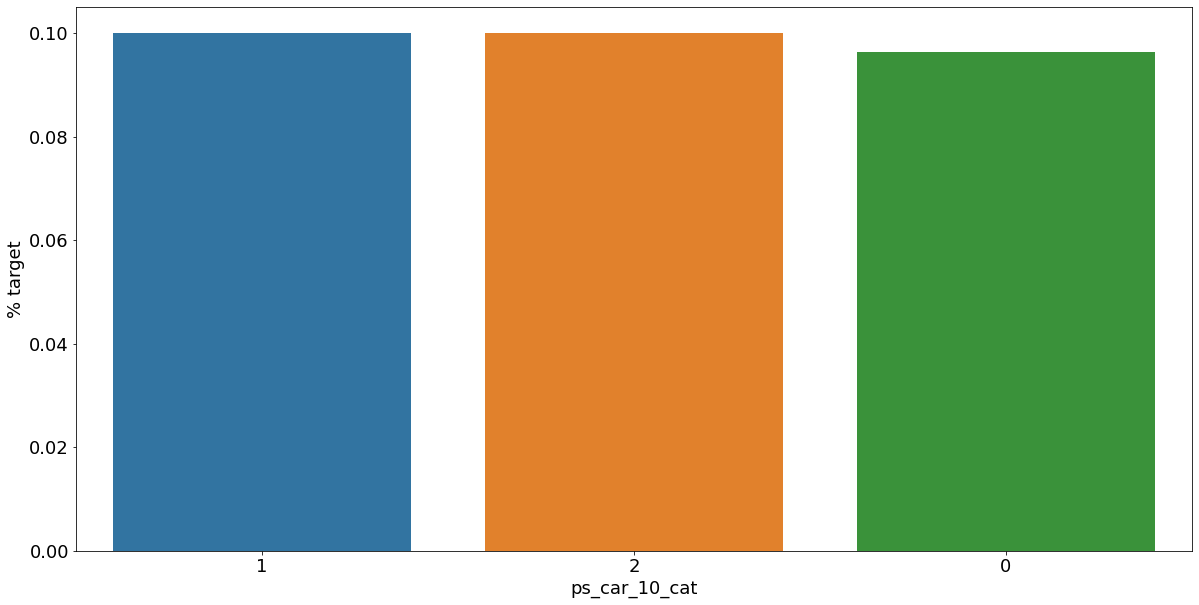

In [28]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    # Calculate the percentage of target = 1 per category value
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

**결측값이 있는** 변수에서 알 수 있듯이 결측값을 모드로 대체하는 대신 별도의 범주 값으로 유지하는 것이 좋습니다. 결측값이 있는 고객은 보험금을 청구할 확률이 훨씬 높은 것으로 보입니다(일부 경우에는 훨씬 더 낮음).

### Interval variables
구간 변수 간의 상관 관계를 확인합니다. 열 지도는 변수 간의 상관 관계를 시각화하는 좋은 방법입니다. 아래 코드는 다음을 기반으로 합니다. [an example by Michael Waskom](http://seaborn.pydata.org/examples/many_pairwise_correlations.html)

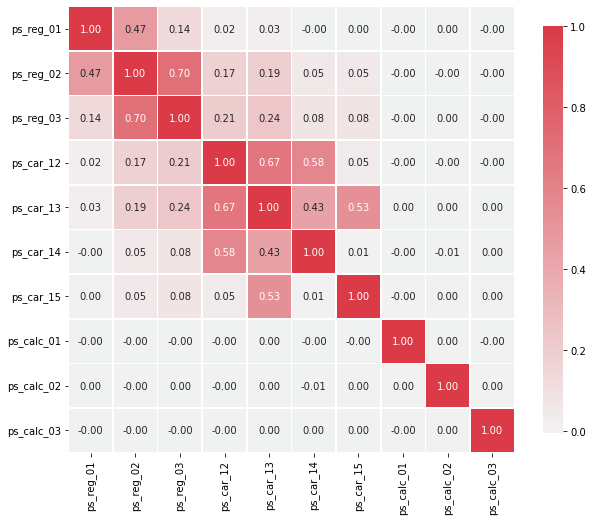

In [29]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

변수들 사이에는 다음과 같은 강한 상관관계가 있다.
- ps_reg_02 및 ps_reg_03(0.7)
- ps_car_12 및 ps_car13(0.67)
- ps_car_12 및 ps_car14(0.58)
- ps_car_13 및 ps_car15(0.67)

Seaborn에는 변수 간의 (선형) 관계를 시각화하는 데 유용한 그림이 있습니다. *pairplot*을 사용하여 변수 간의 관계를 시각화할 수 있습니다. 하지만 열 지도에서는 이미 제한된 수의 상관 변수를 보여 주었기 때문에 상관 관계가 높은 변수 각각을 따로 살펴보도록 하겠습니다.<br>
**참고**: 작업 속도를 높이기 위해 훈련 데이터의 샘플을 채취합니다.

In [30]:
s = train.sample(frac=0.1)

#### ps_reg_02 and ps_reg_03
As the regression line shows, there is a linear relationship between these variables. Thanks to the *hue* parameter we can see that the regression lines for target=0 and target=1 are the same.

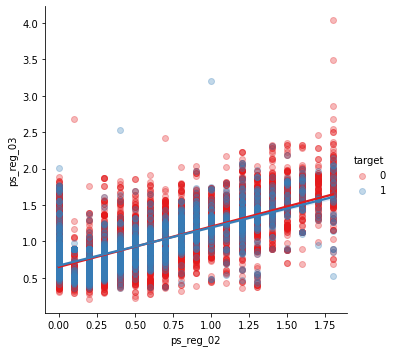

In [31]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_12 and ps_car_13

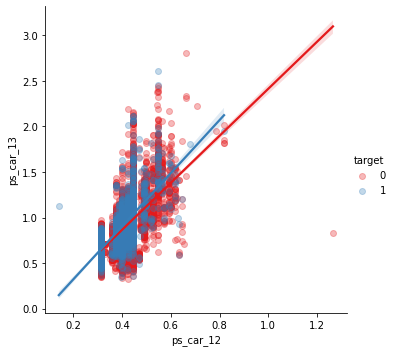

In [32]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_12 and ps_car_14

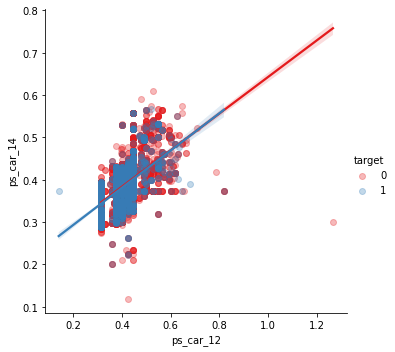

In [33]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_13 and ps_car_15

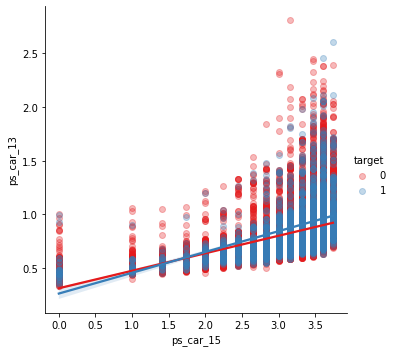

In [34]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

좋아, 이제 어쩌지? 어떤 상관 변수를 유지할 것인지 어떻게 결정할 수 있을까요? 우리는 치수를 줄이기 위해 변수에 대해 주성분 분석(PCA)을 수행할 수 있다. AllState Claims Severity Competition에서 이를 위해 [이 커널](https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca)을 만들었습니다. 하지만 상관 변수의 수가 다소 적기 때문에 우리는 모델이 헤비 리프트를 하도록 할 것입니다.

### Checking the correlations between ordinal variables

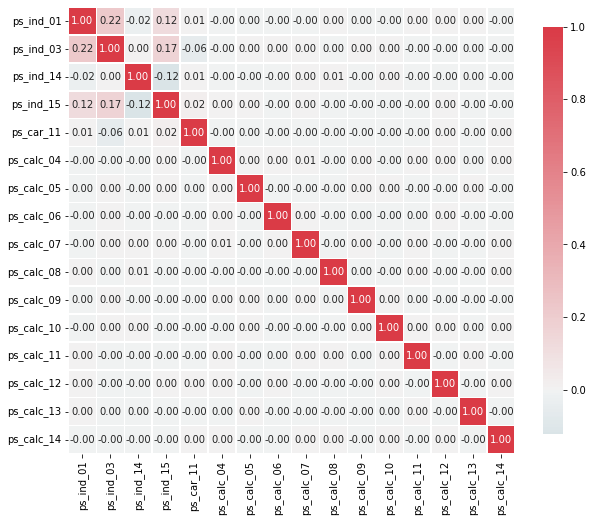

In [35]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

순서형 변수의 경우 많은 상관 관계를 볼 수 없습니다. 반면에 목표값에 따라 그룹화할 때 분포가 어떻게 되는지 살펴볼 수 있습니다.

## Feature engineering

### Creating dummy variables
범주형 변수의 값은 순서나 크기를 나타내지 않습니다. 예를 들어, 범주 2는 범주 1의 값의 두 배가 아닙니다. 따라서 우리는 그것을 다룰 더미 변수를 만들 수 있습니다. 이 정보가 원래 변수의 범주에 대해 생성된 다른 더미 변수에서 파생될 수 있으므로 첫 번째 더미 변수를 삭제한다.

In [36]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


So, creating dummy variables adds 52 variables to the training set.

### Creating interaction variables

In [37]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


이는 훈련 데이터에 추가 상호작용 변수를 추가합니다. *get_feature_names* 방법 덕분에 이러한 새 변수에 열 이름을 할당할 수 있습니다.

<a class="anchor" id="feat_selection"></a>

## Feature selection

### Removing features with low or zero variance

개인적으로, 나는 분류기 알고리즘이 어떤 특징을 유지할지를 선택하도록 하는 것을 선호한다. 하지만 우리가 할 수 있는 일이 하나 있습니다. 즉, 분산이 없거나 매우 낮은 형상을 제거하는 것입니다. Sklearn은 다음과 같은 편리한 방법을 제공합니다. **분산임계값**. 기본적으로 분산이 0인 피쳐를 제거합니다. 이전 단계에서 제로-분산 변수가 없음을 확인했기 때문에 이 경쟁에는 적용되지 않습니다. 하지만 1% 미만의 분산이 있는 피쳐를 제거한다면 31개의 변수를 제거할 것입니다.

In [38]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


분산을 기준으로 선택한다면 오히려 많은 변수를 잃게 될 것입니다. 하지만 변수가 많지 않기 때문에 분류자를 선택하도록 하겠습니다. 변수가 더 많은 데이터 집합의 경우 처리 시간을 단축할 수 있습니다.

Sklearn에는 다른 [feature selection methods](http://scikit-learn.org/stable/modules/feature_selection.html)도 함께 제공됩니다. 이러한 방법 중 하나는 *SelectFromModel*으로, 이 방법을 통해 다른 분류자가 최상의 기능을 선택하고 이러한 기능을 계속할 수 있습니다. 아래에서는 랜덤 포레스트로 어떻게 하는지 보여드리겠습니다.

### Selecting features with a Random Forest and SelectFromModel
여기서는 랜덤 포레스트의 피쳐 중요도를 기준으로 피쳐 선택을 합니다. 그런 다음 Sklearn의 SelectFromModel을 사용하여 유지할 변수 수를 지정할 수 있습니다. 기능 중요도 수준에 대한 임계값을 수동으로 설정할 수 있습니다. 상위 50%의 변수를 선택하기만 하면 됩니다. 

> 아래 셀의 코드는 [GitHub repo of Sebastian Raschka](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb)에서 차용한 것입니다. 이 레포에는 그의 책 *Python Machine Learning*의 코드 샘플이 포함되어 있는데, 이 샘플은 반드시 읽어야 합니다.

In [41]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, verbose=1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 17.1min finished


 1) ps_car_11_cat_te               0.021225
 2) ps_car_13                      0.017380
 3) ps_car_12 ps_car_13            0.017284
 4) ps_car_13^2                    0.017262
 5) ps_car_13 ps_car_14            0.017101
 6) ps_reg_03 ps_car_13            0.017082
 7) ps_reg_01 ps_car_13            0.016786
 8) ps_car_13 ps_car_15            0.016721
 9) ps_reg_03 ps_car_14            0.016292
10) ps_reg_03 ps_car_12            0.015626
11) ps_reg_03 ps_car_15            0.015135
12) ps_car_14 ps_car_15            0.015073
13) ps_car_13 ps_calc_01           0.014786
14) ps_reg_01 ps_reg_03            0.014736
15) ps_reg_02 ps_car_13            0.014691
16) ps_car_13 ps_calc_03           0.014689
17) ps_car_13 ps_calc_02           0.014634
18) ps_reg_01 ps_car_14            0.014388
19) ps_reg_03                      0.014270
20) ps_reg_03^2                    0.014196
21) ps_reg_03 ps_calc_02           0.013796
22) ps_reg_03 ps_calc_03           0.013789
23) ps_reg_03 ps_calc_01        

SelectFromModel을 사용하면 사용할 사전 적합 분류기와 형상 중요도에 대한 임계값을 지정할 수 있다. *get_support* 방법을 사용하면 훈련 데이터의 변수 수를 제한할 수 있습니다.

In [42]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [43]:
train = train[selected_vars + ['target']]

<a class="anchor" id="feat_scaling"></a>

## Feature scaling
앞서 언급했듯이, 우리는 훈련 데이터에 표준 스케일링을 적용할 수 있습니다. 이 작업이 완료되면 일부 분류기가 더 잘 작동합니다.

In [44]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])